In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.data.components import normalize_tensor
from sklearn import preprocessing
from src.utils.preprocessing import LogitScaler

2023-11-26 23:33:01.835245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 23:33:02.569731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
filepath = "/beegfs/desy/user/sommerhm/generative_challenge_2023/outerdata_kfold_1.npy"

In [4]:
data = np.load(filepath)

In [5]:
print(data.shape)

(344531, 5)


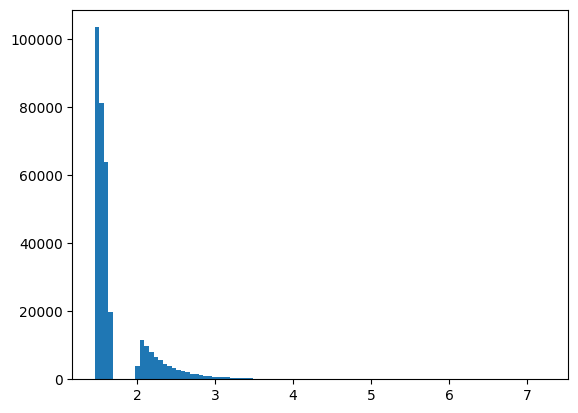

In [6]:
plt.hist(data[:,0], bins=100)
plt.show()

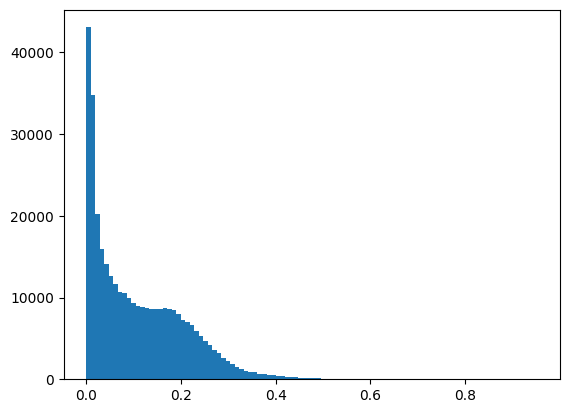

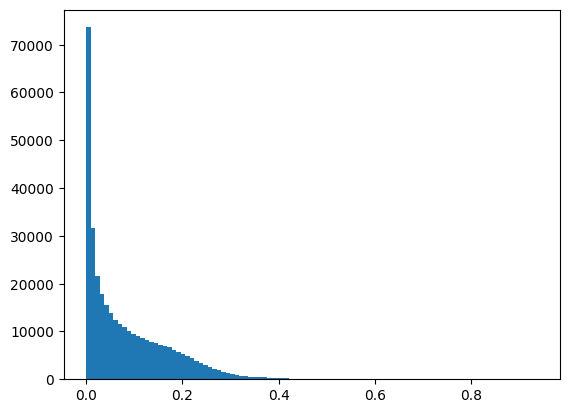

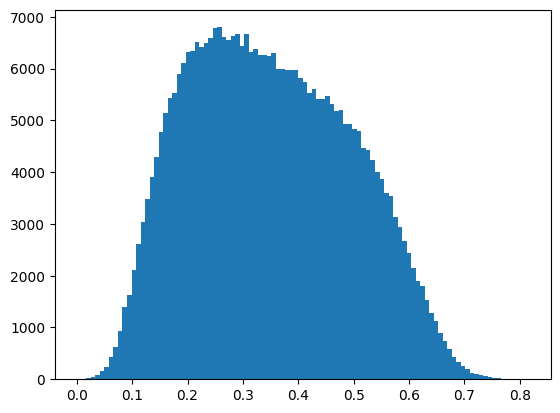

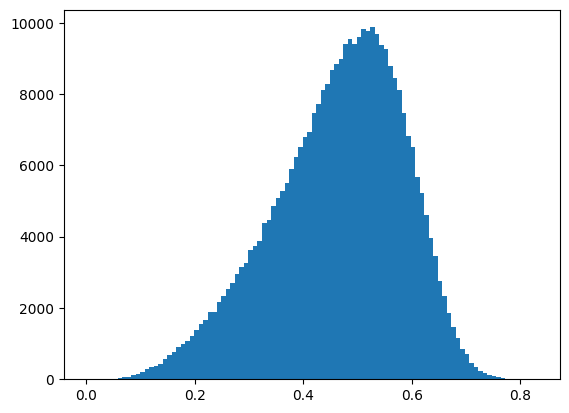

In [7]:
for i in range(1,5):
    plt.hist(data[:,i], bins=100)
    plt.show()

In [8]:
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
normalized_data_1 = normalize_tensor(
    np.copy(data), means, stds, sigma=1
)
print(means)
print(stds)

[1.7247276  0.10920091 0.08457768 0.34899586 0.46429163]
[0.39565107 0.09759869 0.08697253 0.14400777 0.11977484]


In [9]:
scaler = preprocessing.StandardScaler().fit(data)
print(scaler.mean_)
print(scaler.scale_)
normalized_data_2 = scaler.transform(data)

[1.72462664 0.10920248 0.08458071 0.34899656 0.46429606]
[0.39564909 0.09760222 0.08697604 0.14401363 0.11977993]


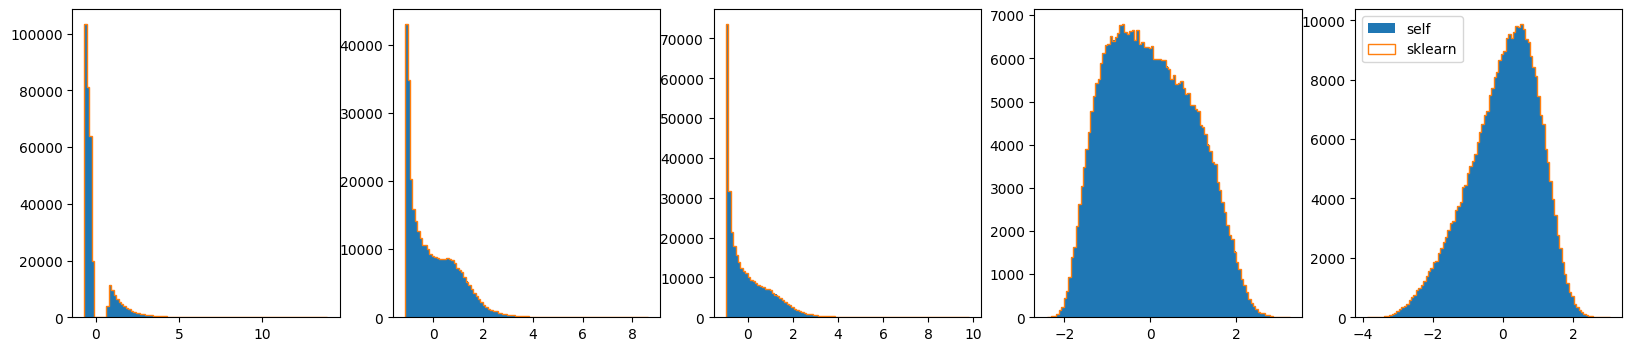

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    hist = ax[i].hist(normalized_data_1[:, i], bins=100, label="self")
    ax[i].hist(normalized_data_2[:, i], bins=hist[1], label="sklearn", histtype="step")
plt.legend()
    
plt.show()


In [11]:
from sklearn.pipeline import make_pipeline


scaler = make_pipeline(LogitScaler(), preprocessing.StandardScaler()).fit(data)
processed_data = scaler.transform(data)

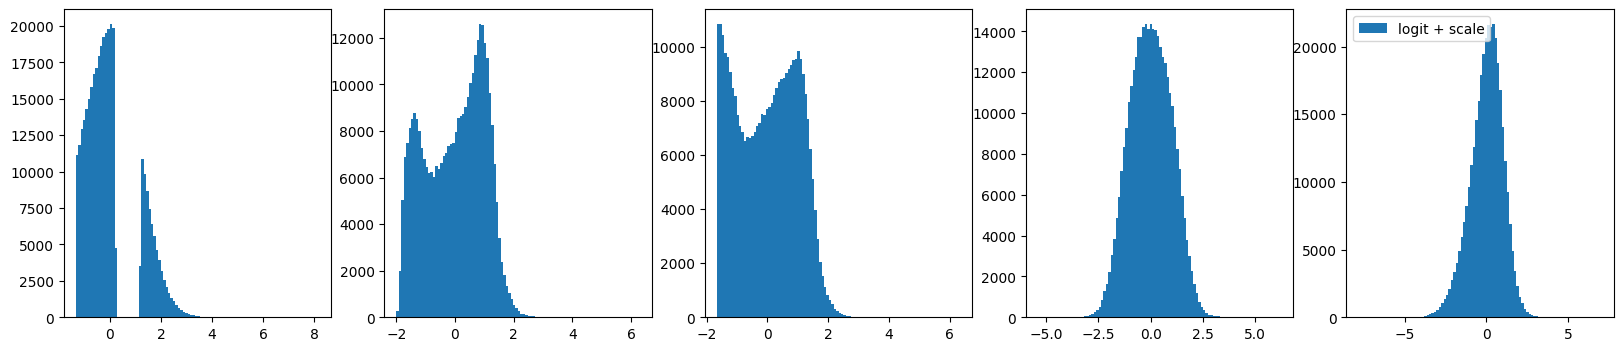

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    hist = ax[i].hist(processed_data[:, i], bins=100, label="logit + scale")
plt.legend()
    
plt.show()

In [13]:
data_back = scaler.inverse_transform(processed_data)

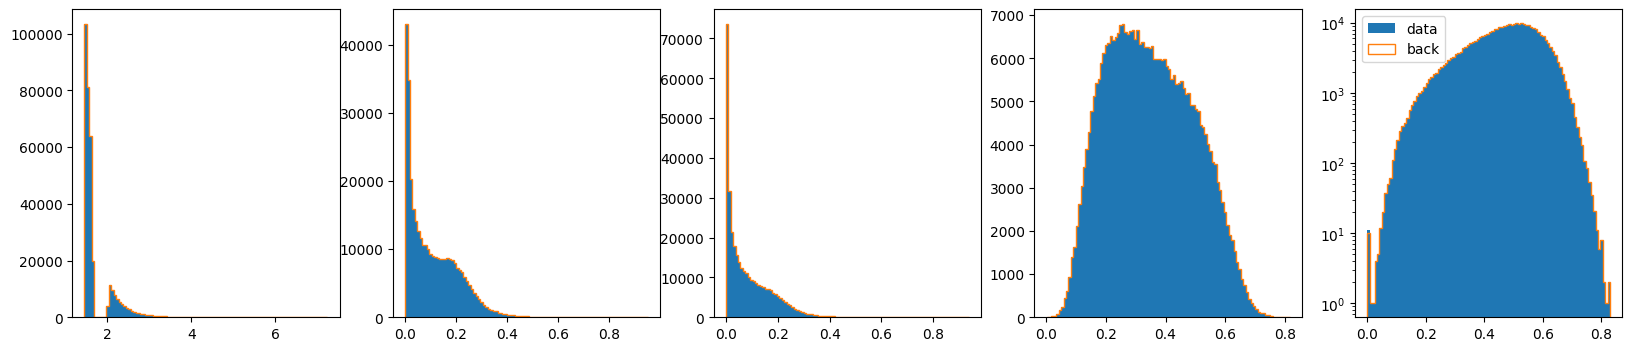

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    hist = ax[i].hist(data[:, i], bins=100, label="data")
    ax[i].hist(data_back[:, i], bins=hist[1], label="back", histtype="step")
plt.legend()
plt.yscale("log")
plt.show()

# Evaluation

In [45]:
import hydra
import torch
from omegaconf import OmegaConf
from os.path import join
from src.utils.data_generation import generate_data_v2

In [16]:
folder = "/beegfs/desy/user/ewencedr/deep-learning/logs/gen_challenge_flow_matching_jet_features/runs/2023-11-26_23-07-38/"

load config

In [17]:
cfg_backup_file = join(folder, "config.yaml")
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    if os.path.exists(cfg_backup_file):
        print("config file already exists --> loading from run directory")
    else:
        raise FileNotFoundError("config file not found")
cfg = OmegaConf.load(cfg_backup_file)

config file already exists --> loading from run directory


instantiate model and data module

In [18]:
datamodule = hydra.utils.instantiate(cfg.data)
model = hydra.utils.instantiate(cfg.model)

datamodule.setup()

tensor train: torch.Size([1033593, 4])
mask train: torch.Size([1033593, 1])
tensor conditioning train: torch.Size([1033593, 1])
tensor train dtype torch.float32
mask train dtype torch.float32
tensor conditioning train dtype torch.float32
Tensor train: 0
Mask train: 0
Tensor conditioning train: 0
Train dataset size: 1033593
Validation dataset size: 344531
Test dataset size: 344527


load checkpoint

In [19]:
ckpt = join(folder, "checkpoints", "last-EMA.ckpt")
model = model.load_from_checkpoint(ckpt)

### Generate Conditioning

In [33]:
data_load0_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_0.npy")
data_load1_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_1.npy")
data_load2_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_2.npy")
data_load3_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_3.npy")
data_load4_sr = np.load("/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_4.npy")
data_load_list_sr = [
    data_load0_sr,
    data_load1_sr,
    data_load2_sr,
    data_load3_sr,
    data_load4_sr,
]
innerdata_train = np.concatenate(
    [
        data_load_list_sr[i]
        for i in range(5)
        if i not in datamodule.hparams.val_sets + datamodule.hparams.test_sets
    ],
    axis=0,
)

In [42]:
test_data_number = datamodule.hparams.test_sets[0]
innerdata_test = np.load(f"/beegfs/desy/user/sommerhm/generative_challenge_2023/innerdata_kfold_{test_data_number}.npy")

In [34]:
# fitting a KDE for the mass distribution based on the inner training set

# we also perform a logit first to stretch out the hard boundaries
from sklearn.neighbors import KernelDensity


m_scaler = LogitScaler()
m_train = m_scaler.fit_transform(innerdata_train[:, 0:1])

kde_model = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_model.fit(m_train)

# now let's sample 4x the number of training data
m_samples = kde_model.sample(4*len(m_train)).astype(np.float32)
m_samples = m_scaler.inverse_transform(m_samples)

In [35]:
print(m_samples.shape)

(2133732, 1)


pre-process mjj samples for use as conditioning

In [37]:
m_conditioning = datamodule.preprocessing_pipeline_cond.transform(m_samples)

### Generate Samples

In [48]:
torch.manual_seed(1111)
data, generation_time = generate_data_v2(
    model,
    num_jet_samples=len(m_conditioning),
    batch_size=2048,
    cond=torch.Tensor(m_conditioning),
    preprocessing_pipeline=datamodule.preprocessing_pipeline,
    ode_solver="midpoint",
    ode_steps=25,
)

Generating data (2133732 samples). Device: cuda


  0%|          | 0/1041 [00:00<?, ?it/s]

100%|██████████| 1041/1041 [01:02<00:00, 16.60it/s]


In [56]:
samples = np.concatenate([m_samples, data], axis=1)

In [57]:
print(samples.shape)

(2133732, 5)


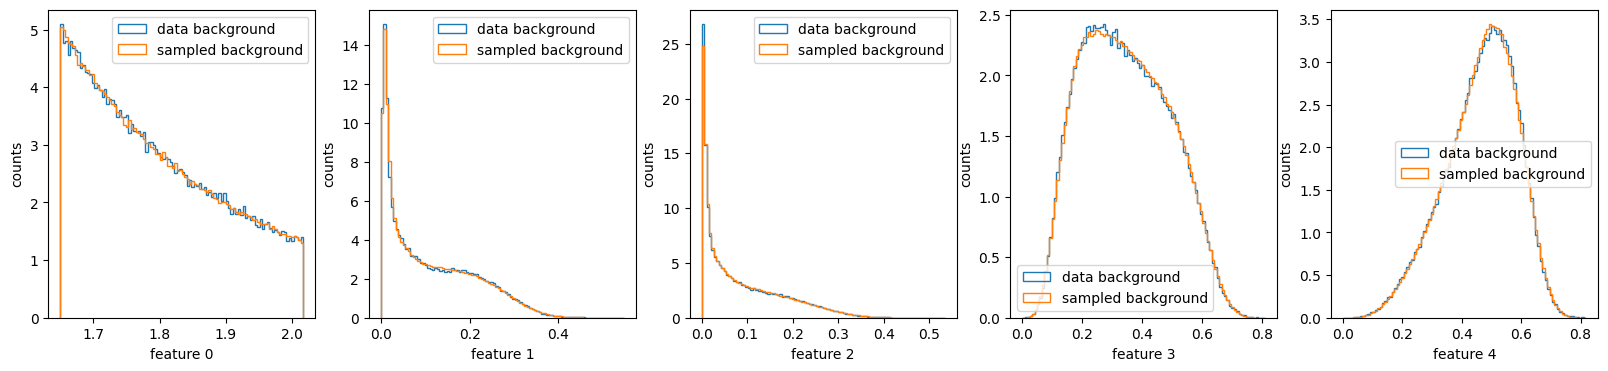

In [67]:
# comparing samples to inner background (idealized sanity check)
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    _, binning, _ = ax[i].hist(innerdata_test[:,i],
                             bins=100, label="data background",
                             density=True, histtype="step")
    _ = ax[i].hist(samples[:, i],
                 bins=binning, label="sampled background",
                 density=True, histtype="step")
    ax[i].legend(loc="best")
    #ax[i].set_ylim(0, plt.gca().get_ylim()[1] * 1.2)
    ax[i].set_xlabel("feature {}".format(i))
    ax[i].set_ylabel("counts")
plt.show()